In [50]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from dateutil import parser
import datetime
from numpy import convolve

from wordcloud import WordCloud, STOPWORDS
from spacy.en import English

# nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import nltk
from nltk.corpus import stopwords

# gensim
import gensim
from gensim import corpora, models, similarities, matutils
from gensim.utils import lemmatize
from gensim.corpora import Dictionary

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

#sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as vaderSentiment
from textblob import TextBlob

# visualization
import pyLDAvis

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


%matplotlib inline

In [51]:
nlp = spacy.load('en')

In [52]:
sns.set_style("whitegrid")

### Import databases

In [53]:
file = open("reviews_botox.obj",'rb')
reviews_nose = pickle.load(file)
file.close()

In [54]:
new_reviews = []
new_review = {}

for review in reviews_nose:
    for post in review['posts']:
        new_review = {}
        new_review['title'] = review['title']
        new_review['breadcrumbs'] = review['breadcrumbs']
        new_review['username'] = review['username']
        new_review['worthit'] = review['worthit']
        new_review['price'] = review['price']
        new_review['doctor'] = review['doctor']
        new_review['location'] = review['location']
        new_review['procedure_date'] = review['procedure_date']
        
        new_review['post_title'] = post['title']
        new_review['body'] = post['body']
        new_review['likes'] = post['likes']
        new_review['tags'] = post['tags']
        new_review['post_date'] = post['post_date']
        new_review['days_from_procedure'] = post['days_from_procedure']
        
        new_reviews.append(new_review)
        
reviews_date = new_reviews

In [55]:
reviews = pd.DataFrame(reviews_nose)

In [56]:
df = pd.DataFrame(reviews_date)
df['treatment'] = df['breadcrumbs'].apply(lambda x: x[1])

## Clean the Data

In [57]:
#df = df.drop(['breadcrumbs', 'tags'], axis = 1)

In [58]:
def price_clean(price):
    price = price.replace(",", "").replace("$","")
    if price != "":
        return int(price)
    else:
        return 0
    
def worthit_clean(worthit):
    if (worthit != 'Worth It') and (worthit != 'Not Worth It') and (worthit != 'Not Sure'):
        return ''
    else:
        return worthit
    
def format_date(day):
    return parser.parse(day)

def get_year(day):
    return day.year

In [59]:
reviews['worthit'] = reviews['worthit'].apply(worthit_clean)
df['worthit'] = df['worthit'].apply(worthit_clean)
worthit = [reviews[reviews['worthit'] == "Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Sure"]['worthit'].count()] 

print("treatment: {}".format(df['treatment'][0]))
print("number of reviews: {}".format(len(reviews)))
print("number of posts: {}".format(len(df)))
print("number of unique users: {}".format(reviews.username.nunique()))
print("number of unique doctors: {}".format(reviews.doctor.nunique()))

treatment: Botox
number of reviews: 3286
number of posts: 4004
number of unique users: 3273
number of unique doctors: 1659


In [60]:
df = df[df['procedure_date'] != "None"]
df['post_date'] = df['post_date'].apply(format_date)
df['post_year'] = df['post_date'].apply(get_year)
df_per_year = df.groupby(['post_year']).count()
df_per_year = df_per_year['body'].reset_index

## Topic Modelling (LDA)

In [61]:
def get_tokens(text):  
    """Return lemmatized tokens for each review."""
    text = re.sub(r"http\S+", "hyperlink", text) # replace urls with str hyperlink
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    words = ' '.join(letters_only.lower().split())
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    return ' '.join(filtered)

In [62]:
## Takes 5 min
df['body_lem'] = df['body'].apply(get_tokens)

In [63]:
def print_top_words(model, feature_names, n_top_words = 50):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print ("\nTopic #%d:" % topic_idx)
        print (", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [64]:
#stop words dictionary
nltk_stopwords = stopwords.words('english')+["forehead", "eyebrow",'results', 'feet', 'crow', 'eye', 'frown', 'brow',"botox", "treatment", "procedure", "I'm", "injection", "Injection", "wrinkle", "pron"]
no_features = 1000
no_topics = 5
no_top_words = 30


In [65]:
# with count vectorizer
def get_topics_lda(df, n_topics):   
    count_vect = CountVectorizer(analyzer = "word",
                                       stop_words = nltk_stopwords,
                                       max_features = 1000, 
                                       max_df = 0.8,
                                       min_df = 10,
                                ngram_range = (1,3))
    matrix = count_vect.fit_transform(df)
    vocab = count_vect.get_feature_names()


    # fit transform lda
    lda = LatentDirichletAllocation(n_components=n_topics,
                learning_method='online', learning_offset=50., max_iter=10,
                random_state=0)
    
    doc_topic_dists = lda.fit_transform(matrix)
    
    # print topic words
    print_top_words(lda, vocab)
    
    # prepare pyLDAvis 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = df.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [66]:
## Takes 10 min
all_lda, all_doc_topics, all_prepared = get_topics_lda(df['body_lem'], 4)


Topic #0:
dr, recommend, staff, good, office, go, result, time, feel, make, year, great, always, highly, would, look, experience, professional, see, doctor, highly recommend, take, patient, question, friend, never, care, friendly, answer, amazing, plastic, anyone, take time, work, happy, also, need, visit, trust, make feel, explain, know, comfortable, wonderful, get, appointment, come, like, recommend dr, filler

Topic #1:
look, get, go, day, like, see, line, month, time, year, still, feel, good, think, say, week, take, want, last, really, would, face, tell, unit, back, one, make, result, start, know, much, first, try, even, little, notice, area, never, doctor, since, work, bad, foot, old, use, skin, around, people, two, could

Topic #2:
dr, look, result, line, get, natural, feel, happy, go, filler, want, make, lip, love, time, great, face, first, young, amazing, also, back, year, happy result, skin, painless, love result, first time, smooth, pleased, look natural, around, juvederm, c

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [67]:
pyLDAvis.display(all_prepared)

In [68]:
def get_doc_topics(doc_topic_dist):
    """Return list of topics for documents, given doc topic distribution"""
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

In [69]:
# categorize reviews by most probable topic
df['topic_LDA'] = get_doc_topics(all_doc_topics)

In [70]:
def get_doc_topics_relevant(doc_topic_dist):
    for doc, topic in enumerate(doc_topic_dist):
        if max(topic) > 0.7:
            return (np.argmax(topic))
        else:
            return (-1)
        
topic_LDA_relevant = []
for doc, topic in enumerate(all_doc_topics):
    if max(topic) > 0.7:
        topic_LDA_relevant.append(np.argmax(topic))
    else:
        topic_LDA_relevant.append(-1)
        
# categorize reviews by most probable topic (>0.7)
df['topic_LDA_relevant'] = topic_LDA_relevant

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


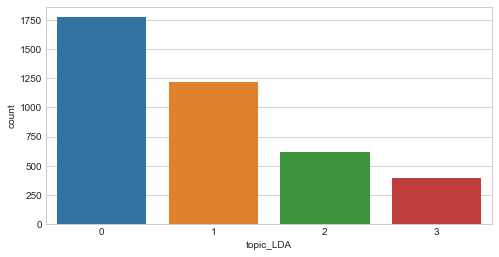

In [71]:
plt.figure(figsize = (8,4))
sns.countplot('topic_LDA', data = df)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


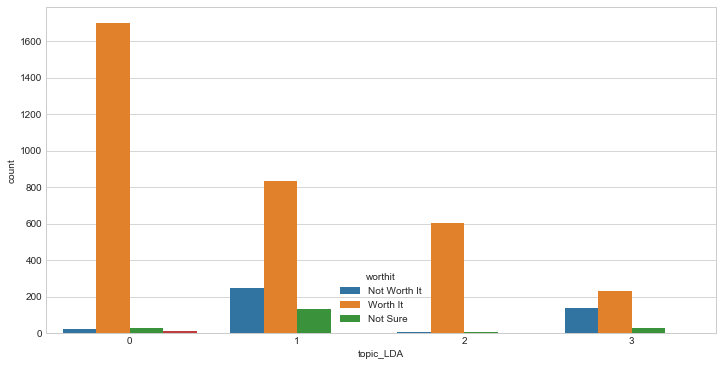

In [72]:
plt.figure(figsize = (12,6))
sns.countplot('topic_LDA', data = df, hue = "worthit")

#### Organize periods

In [73]:
df['days_from_procedure'] = df[df['days_from_procedure'] <= 700]['days_from_procedure']
df['weeks_from_procedure'] = round(df['days_from_procedure'] / 7,0)
#df = df[df['weeks_from_procedure'] >0]

In [74]:
## aggregate days by month
def get_months(day):
    if day >= 365:
        return "over 1 year"
    elif day >= 334:
        return "11"
    elif day >= 303:
        return "10"
    elif day >= 272:
        return "11"
    elif day >= 241:
        return "09"
    elif day >= 211:
        return "08"
    elif day >= 181:
        return "07"
    elif day >= 151:
        return "06"
    elif day >= 121:
        return "05"
    elif day >= 91:
        return "04"
    elif day >= 60:
        return "03"
    elif day >= 30:
        return "02"
    else:
        return "01"
    
df['months_from_procedure'] = df['days_from_procedure'].apply(get_months) 

## Sentiment Analysis

In [75]:
def get_sentences(text):
    """Return list of sentences in tweet."""
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

In [76]:
def get_polarity(sents):
    """Return polarity score for each sentence in text."""
    return [TextBlob(x).sentiment[0] for x in sents]

#def get_vader_sentiment(text):
#    """Return vaderSentiment score for text."""
#    try:
#        return vaderSentiment(text)['compound']
#    except:
#        return 0

In [77]:
df['sentences'] = df['body'].apply(get_sentences)

In [78]:
## Takes 5 min

df['sentiment_scores'] = df['sentences'].apply(get_polarity)

In [79]:
df['avg_sentiment'] = df['sentiment_scores'].apply(np.mean)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


### Set thresholds for negative and positive

In [80]:
def sentiment_threshold(sentiment):
    if sentiment > 0.0:
        return "positive"
    elif sentiment < 0.0:
        return "negative"
    else:
        return "neutral"
    
df['sentiment'] = df['avg_sentiment'].apply(sentiment_threshold)

Text(0.5,1,'Sentiment Distribution')

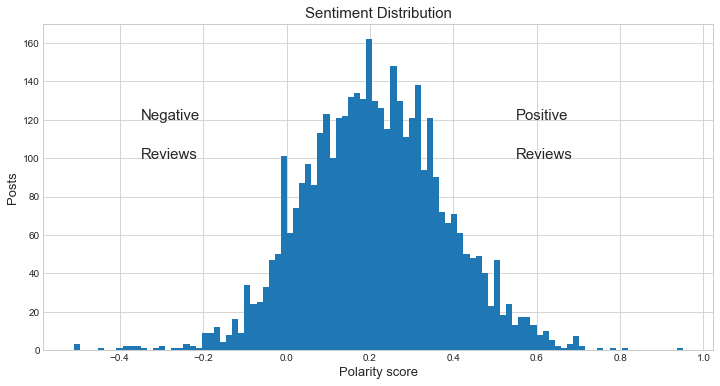

In [81]:
plt.figure(figsize=(12,6))
#sns.plot(df[df['body'] != ""]['avg_sentiment'])
plt.hist(df['avg_sentiment'].dropna(), bins = 100) # ignore NaN's
#plt.axvline(x=-0.05, color="r",linestyle="dashed")
#plt.axvline(x=0.05, color="r",linestyle="dashed")

plt.text(0.55, 120, "Positive", fontsize=15)
plt.text(0.55, 100, "Reviews", fontsize=15)
plt.text(-0.35, 120, "Negative", fontsize=15)
plt.text(-0.35, 100, "Reviews", fontsize=15)

plt.xlabel("Polarity score", fontsize=13)
plt.ylabel("Posts", fontsize=13)
plt.title("Sentiment Distribution", fontsize=15)

### Topic Ratings

In [82]:
df_topic0 = df[df['topic_LDA'] == 0]
df_topic1 = df[df['topic_LDA'] == 1]
df_topic2 = df[df['topic_LDA'] == 2]
df_topic3 = df[df['topic_LDA'] == 3]
#df_topic4 = df[df['topic_LDA'] == 4]
#df_topic5 = df[df['topic_LDA'] == 5]
#df_topic6 = df[df['topic_LDA'] == 6]

print("topic 0 ocurrences: {}".format(len(df_topic0)))
print("topic 1 ocurrences: {}".format(len(df_topic1)))
print("topic 2 ocurrences: {}".format(len(df_topic2)))
print("topic 3 ocurrences: {}".format(len(df_topic3)))
#print("topic 4 ocurrences: {}".format(len(df_topic4)))
#print("topic 5 ocurrences: {}".format(len(df_topic5)))
#print("topic 6 ocurrences: {}".format(len(df_topic6)))

topic 0 ocurrences: 1771
topic 1 ocurrences: 1215
topic 2 ocurrences: 620
topic 3 ocurrences: 398


In [83]:
perc_positiv_0 = len(df_topic0[df_topic0['sentiment'] == 'positive']['sentiment']) / len(df_topic0.dropna())
print ("Topic 0: {}% of the people review positively". format(round(perc_positiv_0 * 100)))

perc_positiv_1 = len(df_topic1[df_topic1['sentiment'] == 'positive']['sentiment']) / len(df_topic1.dropna())
print ("Topic 1: {}% of the people review positively". format(round(perc_positiv_1 * 100)))

perc_positiv_2 = len(df_topic2[df_topic2['sentiment'] == 'positive']['sentiment']) / len(df_topic2.dropna())
print ("Topic 2: {}% of the people review positively". format(round(perc_positiv_2 * 100)))

perc_positiv_3 = len(df_topic3[df_topic3['sentiment'] == 'positive']['sentiment']) / len(df_topic3.dropna())
print ("Topic 3: {}% of the people review positively". format(round(perc_positiv_3 * 100)))

#perc_positiv_4 = len(df_topic4[df_topic4['sentiment'] == 'positive']['sentiment']) / len(df_topic4.dropna())
#print ("Topic 4: {}% of the people review positively". format(round(perc_positiv_4 * 100)))

#perc_positiv_5 = len(df_topic5[df_topic5['sentiment'] == 'positive']['sentiment']) / len(df_topic5['sentiment'])
#print ("Topic 5: {}% of the people review positively". format(round(perc_positiv_5 * 100)))

#perc_positiv_6 = len(df_topic6[df_topic6['sentiment'] == 'positive']['sentiment']) / len(df_topic6['sentiment'])
#print ("Topic 6: {}% of the people review positively". format(round(perc_positiv_6 * 100)))

Topic 0: 99% of the people review positively
Topic 1: 81% of the people review positively
Topic 2: 96% of the people review positively
Topic 3: 79% of the people review positively


#### Ratings for Categories

In [84]:
Procedure = perc_positiv_2
Recovery = perc_positiv_3
Results = (len(df_topic0[df_topic0['sentiment'] == 'positive']['sentiment']) + len(df_topic1[df_topic1['sentiment'] == 'positive']['sentiment'])) / (len(df_topic0.dropna()) + len(df_topic1.dropna())) 

print ("Procedure: {}% of the people review positively". format(round(Procedure * 100)))
print ("Recovery: {}% of the people review positively". format(round(Recovery * 100)))
print ("Results: {}% of the people review positively". format(round(Results * 100)))

Procedure: 96% of the people review positively
Recovery: 79% of the people review positively
Results: 92% of the people review positively


In [94]:
import csv
with open('viz/results_botox.csv', 'w') as csvfile:
    csvfile.write('title,rating\n')
    csvfile.write('Procedure,{}\n'.format(Procedure))
    csvfile.write('Recovery,{}\n'.format(Recovery))
    csvfile.write('Results,{}\n'.format(Results))
    csvfile.close()

#### Plot Graphs

In [85]:
def label_topic(topic):
    if topic == 0:
        return 'Doctor'
    elif topic == 1:
        return 'Result'
    elif topic == 2:
        return 'Procedure'
    else:
        return 'Recovery'

df['topic_label'] = df['topic_LDA'].apply(label_topic)

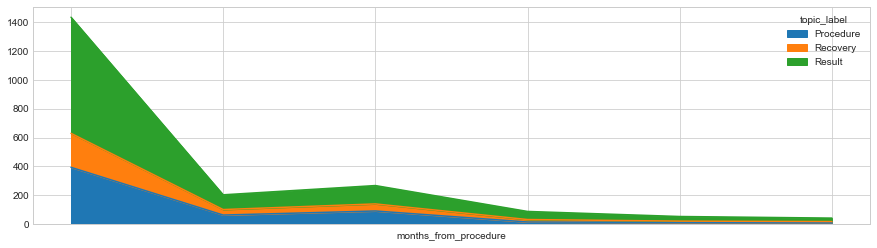

In [86]:
df_period_labels = df[df['topic_label'] != 'Doctor'].groupby(['months_from_procedure','topic_label'])
df_count_posts_labels = df_period_labels.topic_LDA.count()
df_count_posts_labels = df_count_posts_labels.unstack()

## Pplot graph
df_count_posts_labels[:6].plot.area(figsize=(15,4))

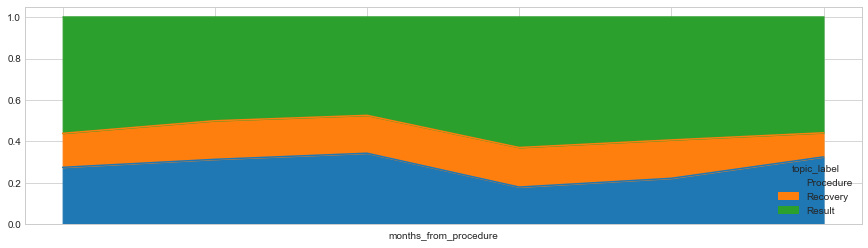

In [88]:
topic_perc_labels = df_count_posts_labels.divide(df_count_posts_labels.sum(axis=1), axis=0)
topic_perc_labels[:6].plot.area(figsize=(15,4))

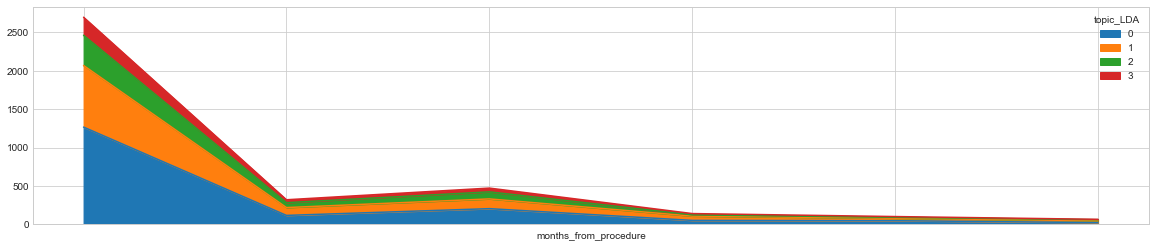

In [89]:
df_period = df.groupby(['months_from_procedure','topic_LDA'])
df_count_posts = df_period.topic_LDA.count()
df_count_posts = df_count_posts.unstack()

## Pplot graph
df_count_posts[:6].plot.area(figsize=(20,4))

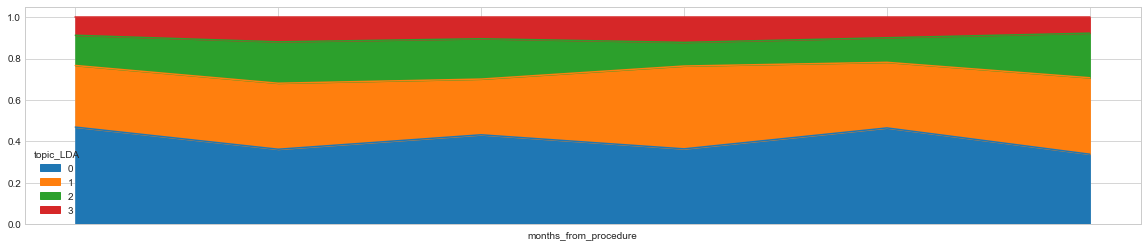

In [90]:
topic_perc = df_count_posts.divide(df_count_posts.sum(axis=1), axis=0)
topic_perc[:6].plot.area(figsize=(20,4))

#### Save DataFrame

In [95]:
pickle.dump(df, open("reviews_topics_botox.pickle",'wb'))

In [92]:
df.to_csv("reviews_topics_botox.csv", encoding='utf-8', index=False)